In [1]:
import scanpy as sc
import anndata as ad
import celltypist
from celltypist import models

In [2]:
# List all of your sample sub-directories under data/
sample_dirs = [
    "Case1-YF", "Case1-ZY",
    "Case2-YF", "Case2-ZC", "Case2-ZY",
    "Case3-YF", "Case3-ZY",
    "Case4-ZY"
]

# Read each 10X matrix and report its shape
for sd in sample_dirs:
    path = f"data/{sd}"
    ad = sc.read_10x_mtx(path, var_names='gene_symbols', cache=True)
    print(f"{sd} shape: {ad.shape}")  # rows=cells, cols=genes


Case1-YF shape: (21560, 33538)
Case1-ZY shape: (13685, 33538)
Case2-YF shape: (11786, 33538)
Case2-ZC shape: (6606, 33538)
Case2-ZY shape: (9406, 33538)
Case3-YF shape: (9379, 33538)
Case3-ZY shape: (8837, 33538)
Case4-ZY shape: (2024, 33538)


In [3]:
# 2) Loop through each, load & QC‐filter
filtered_adatas = {}
for sd in sample_dirs:
    # load
    ad = sc.read_10x_mtx(f"data/{sd}", var_names='gene_symbols', cache=True)
    ad.obs['sample'] = sd
    
    # QC metrics
    ad.var['mt'] = ad.var_names.str.startswith('MT-')
    sc.pp.calculate_qc_metrics(ad, qc_vars=['mt'], inplace=True)
    
    # filters
    sc.pp.filter_cells(ad, min_genes=200)
    sc.pp.filter_cells(ad, max_genes=6000)
    ad = ad[ad.obs.pct_counts_mt < 15, :]
    sc.pp.filter_genes(ad, min_cells=3)
    
    print(f"{sd} post‐filter: {ad.n_obs} cells × {ad.n_vars} genes")
    filtered_adatas[sd] = ad

# Now `filtered_adatas` holds each cleaned AnnData, keyed by sample name.



Case1-YF post‐filter: 6025 cells × 19844 genes
Case1-ZY post‐filter: 7141 cells × 20224 genes
Case2-YF post‐filter: 10946 cells × 21435 genes
Case2-ZC post‐filter: 6248 cells × 18401 genes
Case2-ZY post‐filter: 8915 cells × 22248 genes
Case3-YF post‐filter: 7159 cells × 21386 genes
Case3-ZY post‐filter: 6654 cells × 21726 genes
Case4-ZY post‐filter: 1362 cells × 16207 genes


In [4]:


# the **list** of AnnData objects goes first
adata = sc.concat(
    (sample_dirs),         # <-- wrap in a list!
    label='tissue',             # name of the new obs column
    keys=['Tumor','Metastasis'],# values assigned to that column
    join='inner'                # keep only genes present in all
)


AttributeError: 'str' object has no attribute 'shape'

In [ ]:
import scanpy as sc

# 1) Sample folders and tissue map
sample_dirs = [
    "Case1-YF", "Case1-ZY",
    "Case2-YF", "Case2-ZC", "Case2-ZY",
    "Case3-YF", "Case3-ZY",
    "Case4-ZY"
]
tissue_map = {
    "Case1-YF":"Tumor",
    "Case1-ZY":"Metastasis",
    "Case2-YF":"Tumor",
    "Case2-ZC":"Normal",
    "Case2-ZY":"Metastasis",
    "Case3-YF":"Tumor",
    "Case3-ZY":"Metastasis",
    "Case4-ZY":"Metastasis"
}

# 2) Build list of filtered AnnData objects (from your previous QC step)
ad_list = [filtered_adatas[sd] for sd in sample_dirs]

# 3) Concatenate, labeling by sample (unique!)
adata = sc.concat(
    ad_list,
    label='sample',      # new obs column “sample”
    keys=sample_dirs,    # one‐to‐one with ad_list
    join='inner'
)

# 4) Map sample → tissue
adata.obs['tissue'] = adata.obs['sample'].map(tissue_map)

# 5) Normalize & log1p
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

# 6) Save raw for true fold‐changes
adata.raw = adata.copy()

# 7) Drop mitochondrial genes
non_mito = ~adata.var_names.str.startswith('MT-')
adata = adata[:, non_mito]
adata.raw = adata

# 8) DE between Tumor vs Metastasis (uses raw, so log‐fc is non‐NaN)
sc.tl.rank_genes_groups(
    adata,
    groupby   = 'tissue',
    reference = 'Metastasis',
    method    = 'wilcoxon',
    use_raw   = True
)

# 9) Inspect top Tumor genes
df_tumor = sc.get.rank_genes_groups_df(adata, group='Tumor')
print(df_tumor[['names','logfoldchanges','pvals_adj']].head(10))


... storing 'tissue' as categorical


    names  logfoldchanges  pvals_adj
0  RPL23A        0.737807        0.0
1   RPS18        0.642559        0.0
2   RPL13        0.610172        0.0
3    RPS2        0.685214        0.0
4    LMNA        1.108603        0.0
5   RPL10        0.582234        0.0
6  RPL27A        0.641494        0.0
7    RPS3        0.656968        0.0
8    RPL3        0.666731        0.0
9  HSPA1A        1.031904        0.0


In [ ]:
# all tissue DE results
tissue_markers = sc.get.rank_genes_groups_df(adata, None)
tissue_markers.to_csv('results/tissue_DE_Tumor_vs_Met.csv', index=False)
print("Wrote results/tissue_DE_Tumor_vs_Met.csv")


Wrote results/tissue_DE_Tumor_vs_Met.csv


In [ ]:
import pandas as pd

# assume filtered_adatas holds your post‐QC AnnDatas
records = []
for sd, ad in filtered_adatas.items():
    # you can re‐read the raw matrices to get pre‐QC counts if you want
    raw = sc.read_10x_mtx(f"data/{sd}", var_names='gene_symbols', cache=True)
    records.append({
        "sample": sd,
        "tissue": tissue_map[sd],
        "cells_before": raw.n_obs,
        "genes_before": raw.n_vars,
        "cells_after": ad.n_obs,
        "genes_after": ad.n_vars
    })

df_qc = pd.DataFrame(records)
print(df_qc)
df_qc.to_csv("results/pre_post_qc_summary.csv", index=False)


     sample      tissue  cells_before  genes_before  cells_after  genes_after
0  Case1-YF       Tumor         21560         33538         6025        19844
1  Case1-ZY  Metastasis         13685         33538         7141        20224
2  Case2-YF       Tumor         11786         33538        10946        21435
3  Case2-ZC      Normal          6606         33538         6248        18401
4  Case2-ZY  Metastasis          9406         33538         8915        22248
5  Case3-YF       Tumor          9379         33538         7159        21386
6  Case3-ZY  Metastasis          8837         33538         6654        21726
7  Case4-ZY  Metastasis          2024         33538         1362        16207


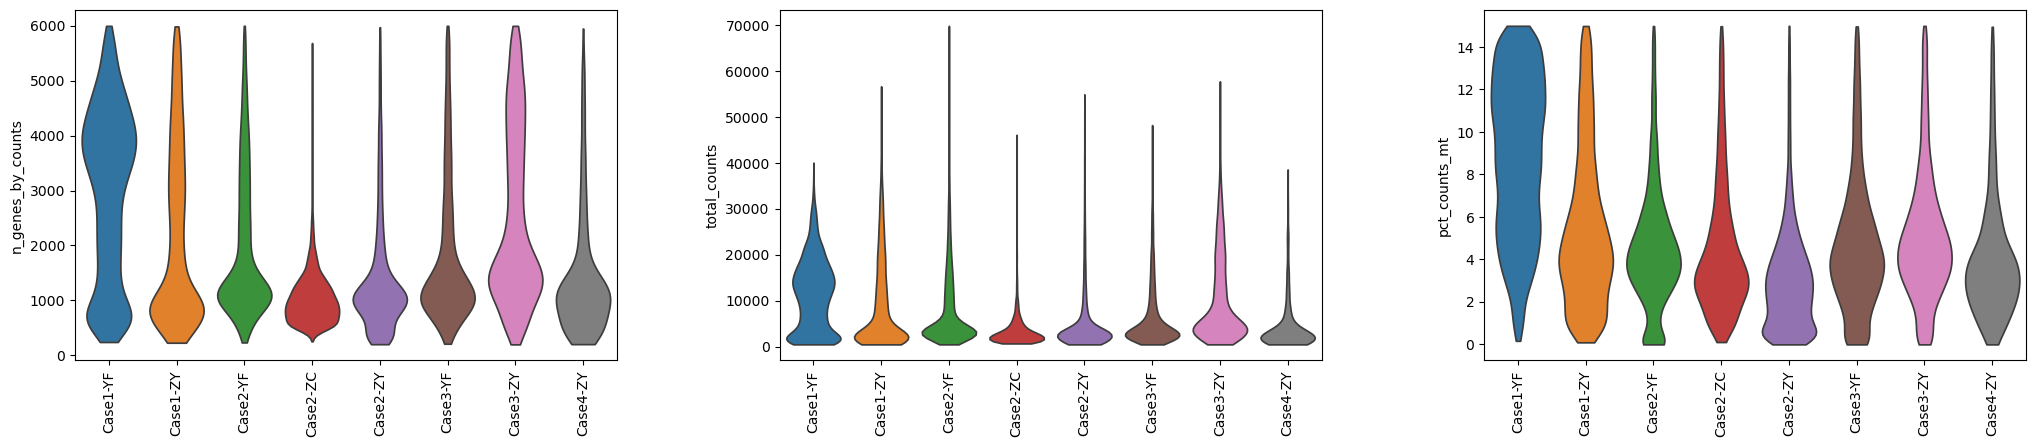

In [ ]:
import scanpy as sc

# Combined QC violin, one panel per metric, grouped by sample
sc.pl.violin(
    adata,
    keys=['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
    groupby='sample',
    stripplot=False,    # turn off jittered points if it gets too busy
    multi_panel=True,
    rotation=90,        # sample labels will be vertical
    size=1.5            # shrink the individual dots
)


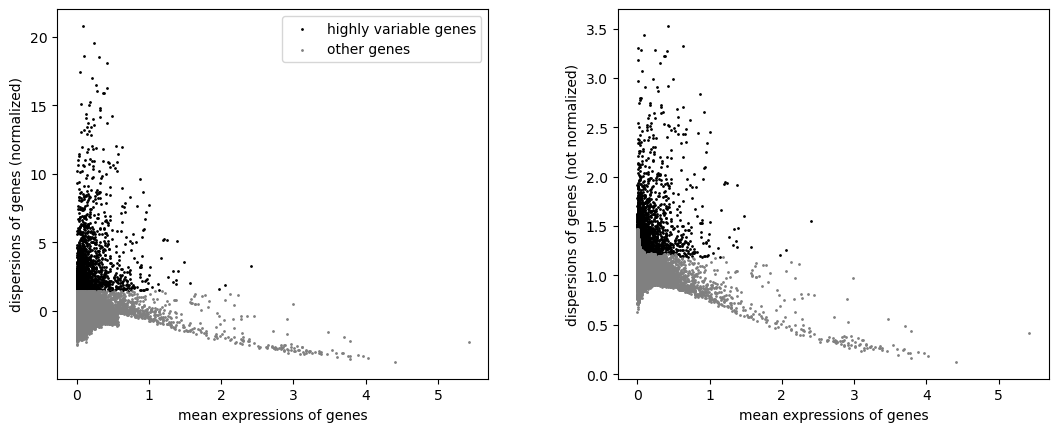

In [ ]:
# 1) Identify 2 000 HVGs with the Cell Ranger method (no extra deps)
sc.pp.highly_variable_genes(
    adata,
    n_top_genes=2000,
    flavor='cell_ranger'
)

# 2) Diagnostic scatter: mean vs dispersion (highlights your HVGs)
sc.pl.highly_variable_genes(adata, show=True)


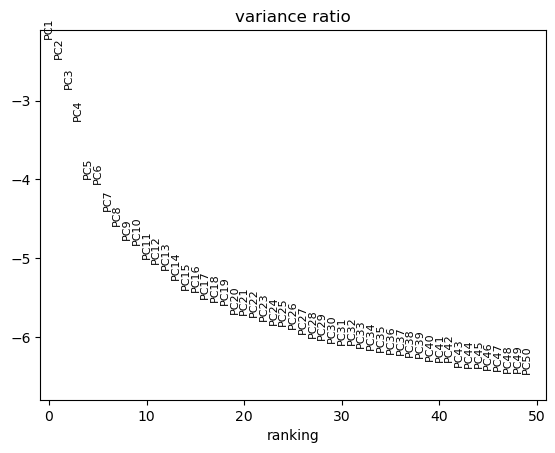

In [ ]:
# PCA was already run with sc.tl.pca(adata, svd_solver='arpack')

# Scree / elbow plot of the first 50 PCs (log scale)
sc.pl.pca_variance_ratio(
    adata,
    n_pcs=50,
    log=True
)



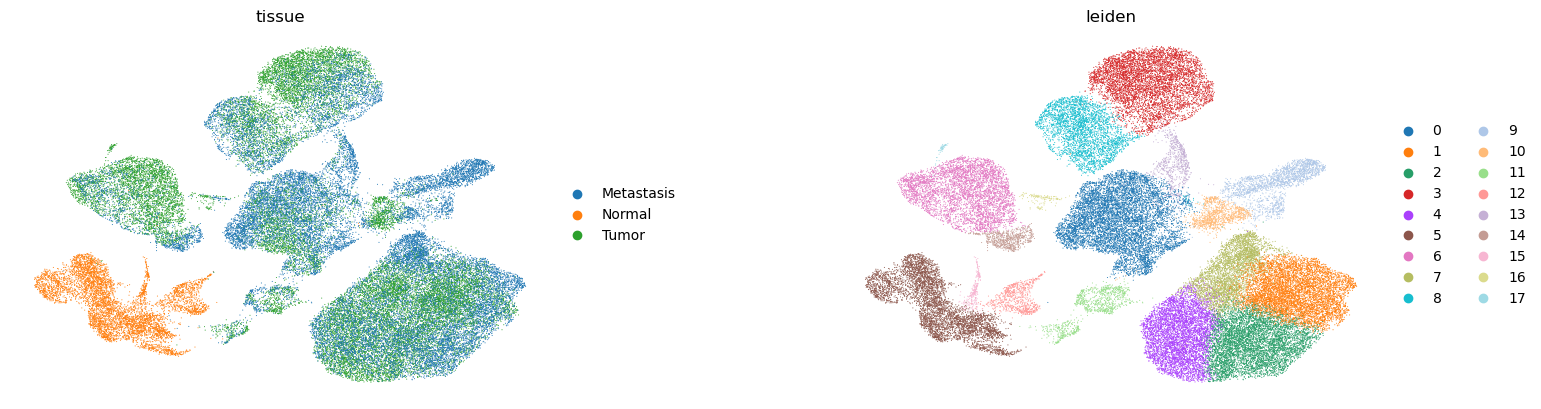

In [ ]:
# 6) Build the k-NN graph on the first 10 PCs
sc.pp.neighbors(adata, n_pcs=10)

# 7) Compute UMAP embedding
sc.tl.umap(adata)

# 8) Cluster with Leiden at your preferred resolution
sc.tl.leiden(adata, resolution=0.5)

# 9) Plot the results
sc.pl.umap(
    adata,
    color=['tissue','leiden'],
    wspace=0.4,
    frameon=False
)



In [ ]:
import matplotlib.pyplot as plt
import os

os.makedirs('figures', exist_ok=True)

# Plot (without showing)
sc.pl.umap(adata, color='tissue', show=False)

# Tight layout + save with extra padding
plt.tight_layout()
plt.savefig(
    'figures/umap_by_tissue.png',
    dpi=300,
    bbox_inches='tight',   # crop to content
    pad_inches=0.1         # add a little white space
)
plt.close()


# Plot by cluster
sc.pl.umap(
    adata,
    color='leiden',
    show=False
)
plt.savefig('figures/umap_by_leiden.png', dpi=300)
plt.close()


In [ ]:
import scrublet as scr
import numpy as np
import pandas as pd
import os

# Your list of sample names and the dict of filtered AnnDatas
sample_dirs = [
    "Case1-YF", "Case1-ZY",
    "Case2-YF", "Case2-ZC", "Case2-ZY",
    "Case3-YF", "Case3-ZY",
    "Case4-ZY"
]

# Where we'll store the summary
records = []

# Make a figures folder if you want to save score histograms
os.makedirs('figures/scrublet', exist_ok=True)

for sd in sample_dirs:
    ad = filtered_adatas[sd]
    
    # 1) Extract the raw counts matrix (dense)
    counts = ad.X.copy()
    if not isinstance(counts, np.ndarray):
        counts = counts.toarray()
    
    # 2) Initialize Scrublet (e.g. 7.5% expected doublets)
    scrub = scr.Scrublet(
        counts,
        expected_doublet_rate=0.075
    )
    
    # 3) Run scrublet — returns scores and boolean calls
    doublet_scores, predicted_doublets = scrub.scrub_doublets(
        min_counts=2,
        min_cells=3,
        n_prin_comps=30
    )
    
    # 4) Add back into AnnData.obs
    ad.obs['doublet_score']      = doublet_scores
    ad.obs['predicted_doublet']  = predicted_doublets
    
    # 5) Summarize call rate
    rate = 100 * np.mean(predicted_doublets)
    records.append({
        "sample": sd,
        "tissue": tissue_map[sd],
        "n_cells": ad.n_obs,
        "doublet_rate_%": rate
    })
    
    # 6) (Optional) save a histogram of the scores
    import matplotlib.pyplot as plt
    plt.figure(figsize=(4,2))
    plt.hist(doublet_scores, bins=50)
    plt.xlabel("Scrublet score")
    plt.ylabel("Cell count")
    plt.title(f"{sd}: {rate:.1f}% doublets")
    plt.tight_layout()
    plt.savefig(f"figures/scrublet/{sd}_scrublet_hist.png", dpi=150)
    plt.close()

# 7) Build & save the summary DataFrame
df_scrub = pd.DataFrame(records).set_index('sample')
print(df_scrub)
df_scrub.to_csv("results/scrublet_summary.csv")


Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.30
Detected doublet rate = 2.7%
Estimated detectable doublet fraction = 26.5%
Overall doublet rate:
	Expected   = 7.5%
	Estimated  = 10.3%
Elapsed time: 12.5 seconds
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.69
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 0.5%
Overall doublet rate:
	Expected   = 7.5%
	Estimated  = 8.0%
Elapsed time: 14.4 seconds
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.73
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 0.3%
Overall doublet rate:
	Expected   = 7.5%
	Estimated  = 0.0%
Elapsed time: 23.3 seconds
Preprocessing...
Simulating doublet

In [ ]:
import scanpy as sc

# 1) Make your list of filtered AnnDatas (with scrublet calls)
ad_list = [filtered_adatas[sd] for sd in sample_dirs]

# 2) Re‐concatenate, labeling by sample
adata = sc.concat(
    ad_list,
    label='sample',
    keys=sample_dirs,
    join='inner'
)

# 3) Re‐derive tissue if needed
adata.obs['tissue'] = adata.obs['sample'].map(tissue_map)

# 4) Now adata.obs includes:
#    - 'doublet_score'
#    - 'predicted_doublet' 
#    - 'sample'
#    - 'tissue'
print(adata.obs[['sample','tissue','doublet_score','predicted_doublet']].head())


                      sample tissue  doublet_score  predicted_doublet
AAACCCAAGGCTGTAG-1  Case1-YF  Tumor       0.033667              False
AAACCCACAAACAGGC-1  Case1-YF  Tumor       0.167136              False
AAACCCAGTACTCGAT-1  Case1-YF  Tumor       0.046528              False
AAACCCAGTGCTGCAC-1  Case1-YF  Tumor       0.034783              False
AAACCCATCACAAGGG-1  Case1-YF  Tumor       0.092025              False


In [ ]:
adata.write_h5ad('results/combined_all_samples_with_doublets.h5ad')


... storing 'tissue' as categorical


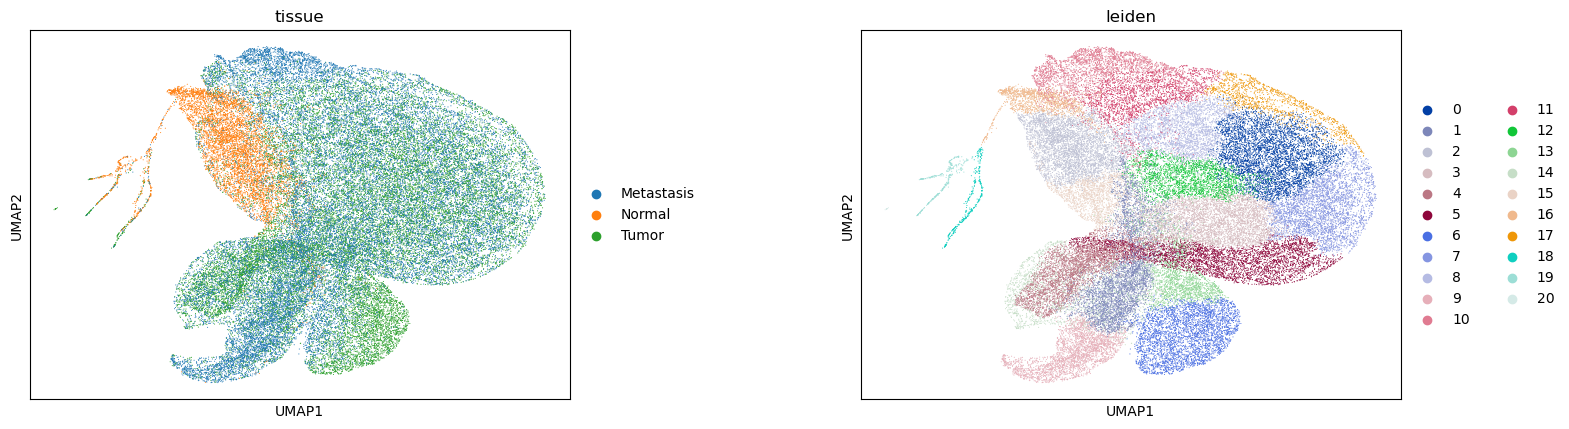

In [ ]:
# 1) Subset to singlets
singlets = adata[adata.obs['predicted_doublet']==False].copy()

# 2) Recompute neighbors (uses the existing PCA in obsm['X_pca'])
#    If you’d rather recompute PCA on singlets, run sc.tl.pca(singlets) first.
sc.pp.neighbors(singlets, n_pcs=10)

# 3) UMAP
sc.tl.umap(singlets)

# 4) Clustering
sc.tl.leiden(singlets, resolution=0.5)

# 5) Plot
sc.pl.umap(singlets, color=['tissue','leiden'], wspace=0.4)



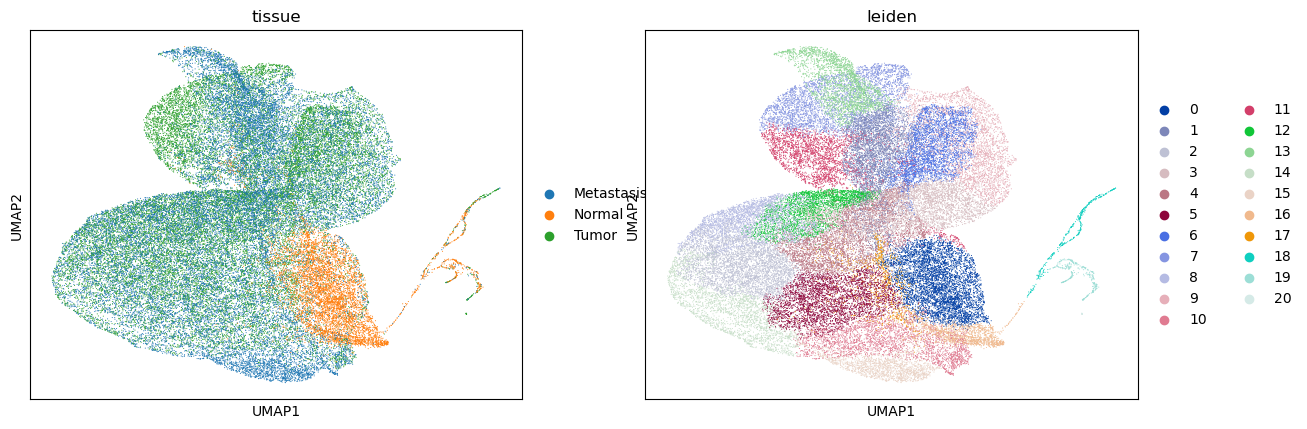

In [ ]:
sc.tl.pca(singlets, svd_solver='arpack')
sc.pp.neighbors(singlets, n_pcs=10)
sc.tl.umap(singlets)
sc.tl.leiden(singlets, resolution=0.5)
sc.pl.umap(singlets, color=['tissue','leiden'])


In [ ]:
singlets.write_h5ad('results/combined_singlets.h5ad')


In [ ]:
import matplotlib.pyplot as plt
plt.tight_layout()
plt.savefig('figures/umap_singlets_vs_all.png', dpi=300, bbox_inches='tight')
plt.close()


Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


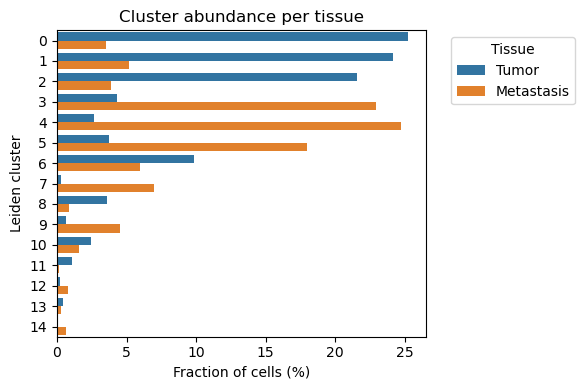

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc

# reload your clustered object
adata = sc.read_h5ad('results/combined_all_samples_scaled.h5ad')

# cross‐tabulate
ct = pd.crosstab(
    adata.obs['leiden'],
    adata.obs['tissue'],
    normalize='columns'
)

df_prop = (
    ct
    .reset_index()
    .melt('leiden', var_name='tissue', value_name='fraction')
)
df_prop['fraction'] *= 100

plt.figure(figsize=(6,4))
sns.barplot(data=df_prop, x='fraction', y='leiden', hue='tissue')
plt.xlabel('Fraction of cells (%)')
plt.ylabel('Leiden cluster')
plt.title('Cluster abundance per tissue')
plt.legend(title='Tissue', bbox_to_anchor=(1.05,1), loc='upper left')
plt.tight_layout()
plt.savefig('figures/cluster_proportions_by_tissue.png', dpi=300)
plt.show()


In [ ]:
# merge all 8 samples (including Case2-ZC)
ad_list = [filtered_adatas[sd] for sd in sample_dirs]  # sample_dirs includes Case2-ZC
adata = sc.concat(
    ad_list,
    label='sample',
    keys=sample_dirs,
    join='inner'
)
adata.obs['tissue'] = adata.obs['sample'].map(tissue_map)
# now `adata.obs['tissue']` contains “Normal” and you can root on it


/projectnb/bf528/students/nwhite42/.conda/envs/scanpy_scrnaseq/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<Figure size 500x400 with 0 Axes>

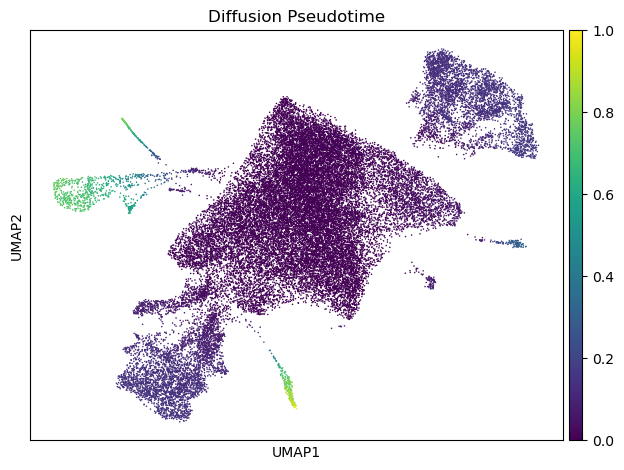

In [6]:
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
import os

# 1) Load your merged AnnData (with Tumor, Metastasis, Normal)
adata = sc.read_h5ad('results/combined_all_samples_scaled.h5ad')

# 2) Compute diffusion map (10 diffusion components)
sc.tl.diffmap(adata, n_comps=10)

# 3) Build kNN graph on the diffusion map embedding
sc.pp.neighbors(adata, n_neighbors=15, use_rep='X_diffmap')

# 4) Choose a “root” cell index: prefer Normal tissue, else Tumor
if 'Normal' in adata.obs['tissue'].unique():
    root_ix = np.flatnonzero(adata.obs['tissue']=='Normal')[0]
else:
    root_ix = np.flatnonzero(adata.obs['tissue']=='Tumor')[0]
adata.uns['iroot'] = int(root_ix)

# 5) Run Diffusion Pseudotime (DPT) using that root
sc.tl.dpt(adata, n_dcs=10)

# 6) Save the updated AnnData (with dpt_pseudotime) for downstream
os.makedirs('results', exist_ok=True)
adata.write_h5ad('results/combined_with_dpt.h5ad')

# 7) Plot UMAP colored by pseudotime and save
os.makedirs('figures', exist_ok=True)
plt.figure(figsize=(5,4))
sc.pl.umap(
    adata,
    color='dpt_pseudotime',
    cmap='viridis',
    size=5,
    show=False
)
plt.title('Diffusion Pseudotime')
plt.tight_layout()
plt.savefig('figures/umap_dpt_pseudotime.png', dpi=300, bbox_inches='tight')
plt.show()


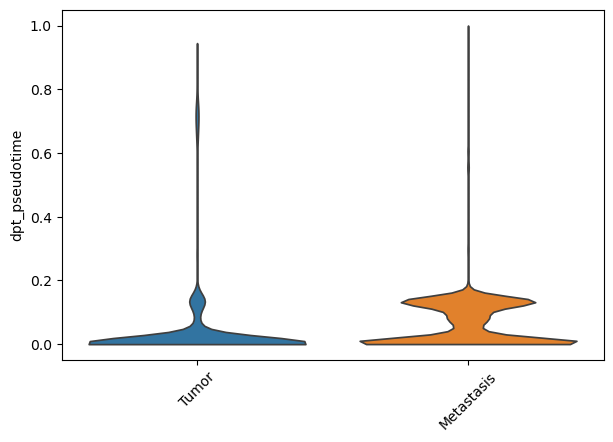

In [7]:
sc.pl.violin(
    adata,
    keys='dpt_pseudotime',
    groupby='tissue',
    stripplot=False,
    rotation=45
)


In [ ]:
import numpy as np
import scanpy as sc

# 1) Ensure neighbors & UMAP are computed (they are)
# sc.pp.neighbors(adata, n_pcs=10)
# sc.tl.umap(adata)

# 2) Choose a root cell: the first Normal cell
normal_cells = np.where(adata.obs['tissue']=='Normal')[0]
root_index   = normal_cells[0]

# 3) Run DPT
sc.tl.dpt(
    adata,
    n_dcs=10,           # use first 10 diffusion components
    root_key=root_index,
    key_added='dpt_pseudotime'
)

# 4) Plot pseudotime on UMAP
plt.figure(figsize=(5,4))
sc.pl.umap(
    adata,
    color='dpt_pseudotime',
    cmap='viridis',
    size=5,
    show=False
)
plt.title('Diffusion Pseudotime')
plt.tight_layout()
plt.savefig('figures/umap_dpt_pseudotime.png', dpi=300)
plt.show()


TypeError: dpt() got an unexpected keyword argument 'root_key'

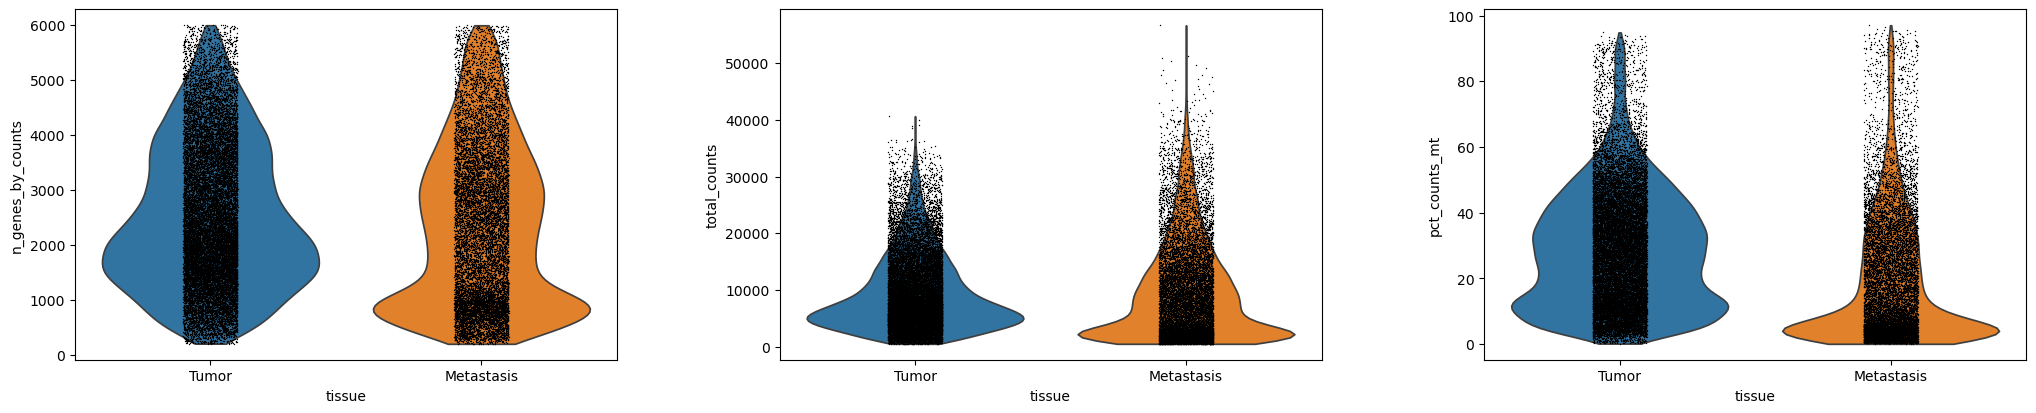

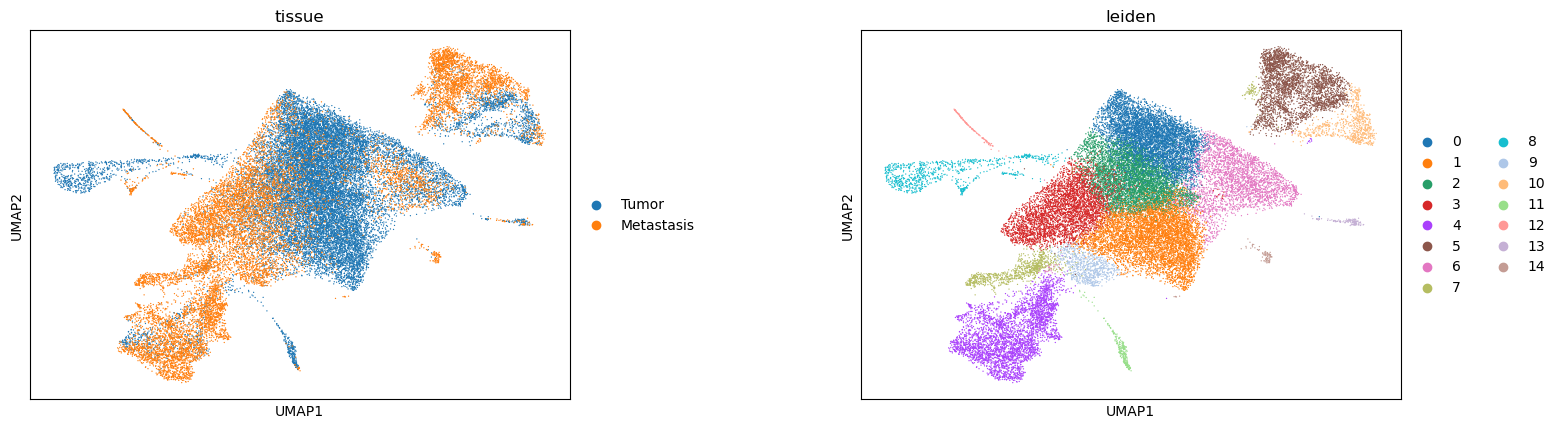

Written to results/combined_all_samples_scaled.h5ad


In [ ]:
# 5) PCA → neighbors → UMAP → Leiden clustering
sc.tl.pca(adata, svd_solver='arpack')
sc.pp.neighbors(adata, n_pcs=30)
sc.tl.umap(adata)
sc.tl.leiden(adata, resolution=0.5)

# 6) Quick QC‐and‐embedding plots
sc.pl.violin(
    adata,
    ['n_genes_by_counts','total_counts','pct_counts_mt'],
    groupby='tissue',
    multi_panel=True
)
sc.pl.umap(adata, color=['tissue','leiden'], wspace=0.4)

# 7) (Re)stash raw for DE, if you haven’t already
adata.raw = adata

# 8) Save your processed object
import os
os.makedirs('results', exist_ok=True)
adata.write_h5ad('results/combined_all_samples_scaled.h5ad')
print("Written to results/combined_all_samples_scaled.h5ad")


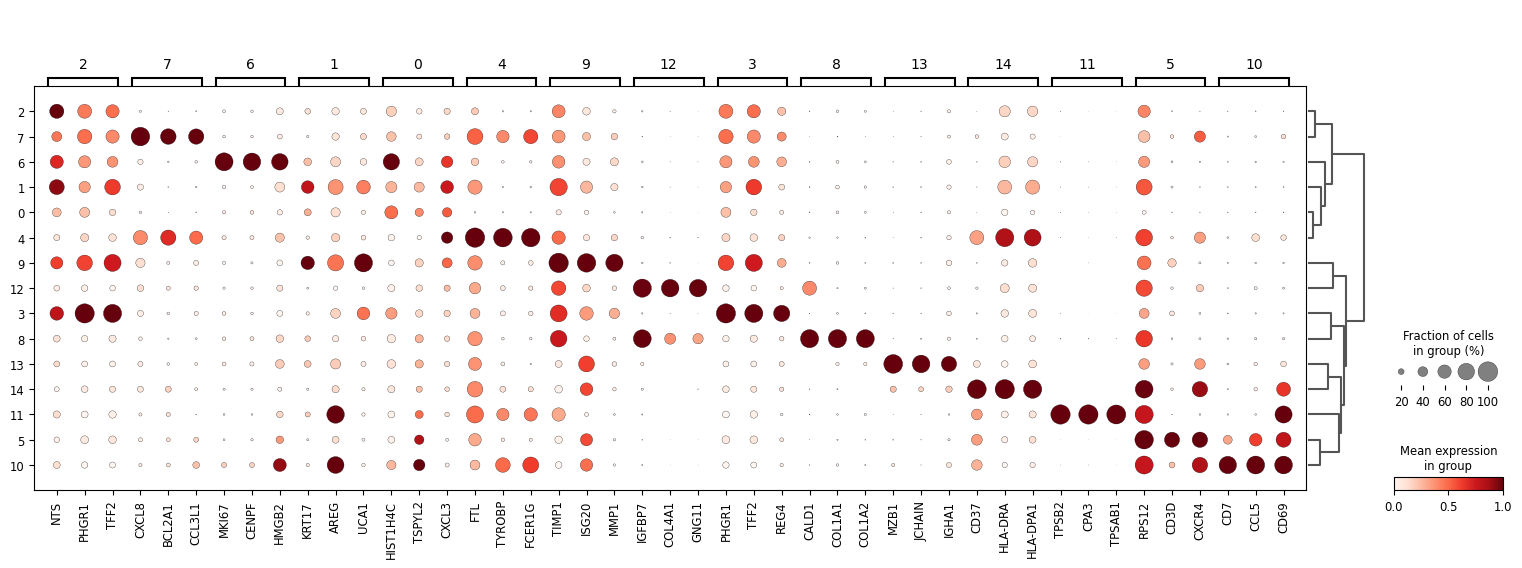

In [ ]:
# Rank markers for each cluster
sc.tl.rank_genes_groups(
    adata,
    groupby='leiden',
    method='wilcoxon',
    use_raw=True
)

# Dotplot the top 3 per cluster
sc.pl.rank_genes_groups_dotplot(
    adata,
    n_genes=3,
    groupby='leiden',
    standard_scale='var',
    dendrogram=True
)


      names     scores  logfoldchanges         pvals     pvals_adj
0  HIST1H4C  19.938320             NaN  1.893185e-88  4.732964e-87
1    TSPYL2   6.809174             NaN  9.816100e-12  6.840488e-11
2     CXCL3   4.851400             NaN  1.225929e-06  7.086295e-06
3     KRT17   2.096564             NaN  3.603220e-02  1.344485e-01
4     IGLC2   1.515914             NaN  1.295412e-01  4.192271e-01


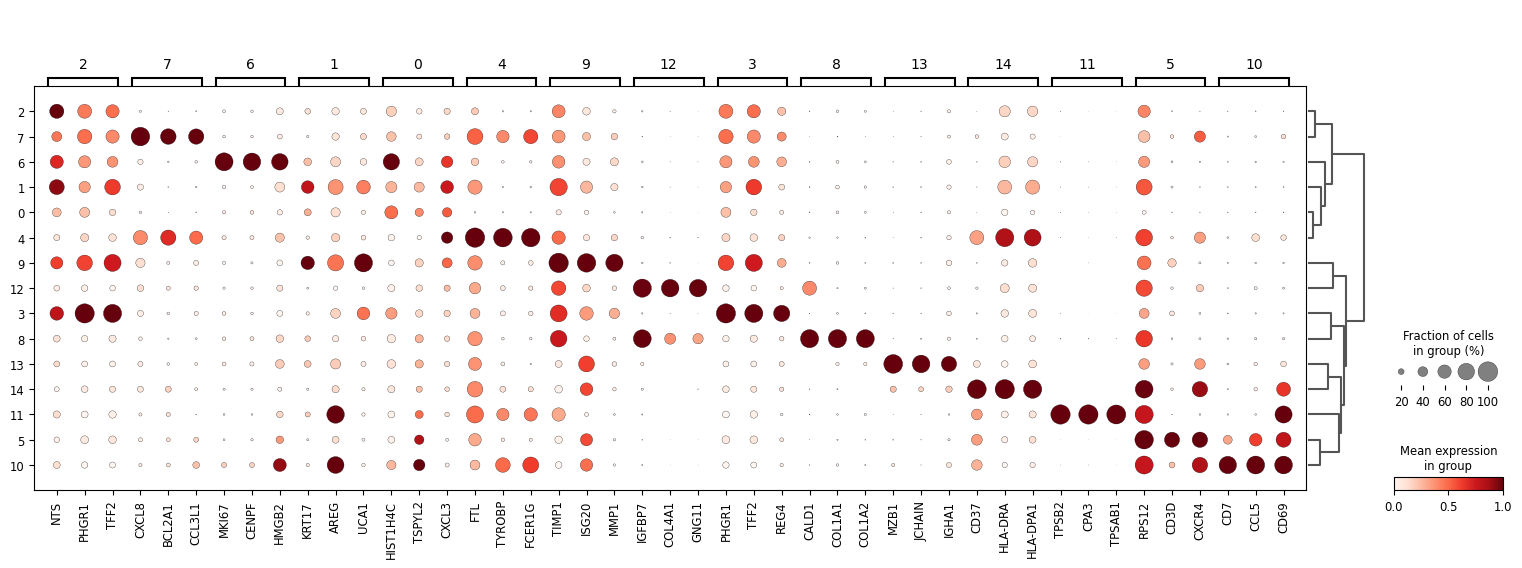

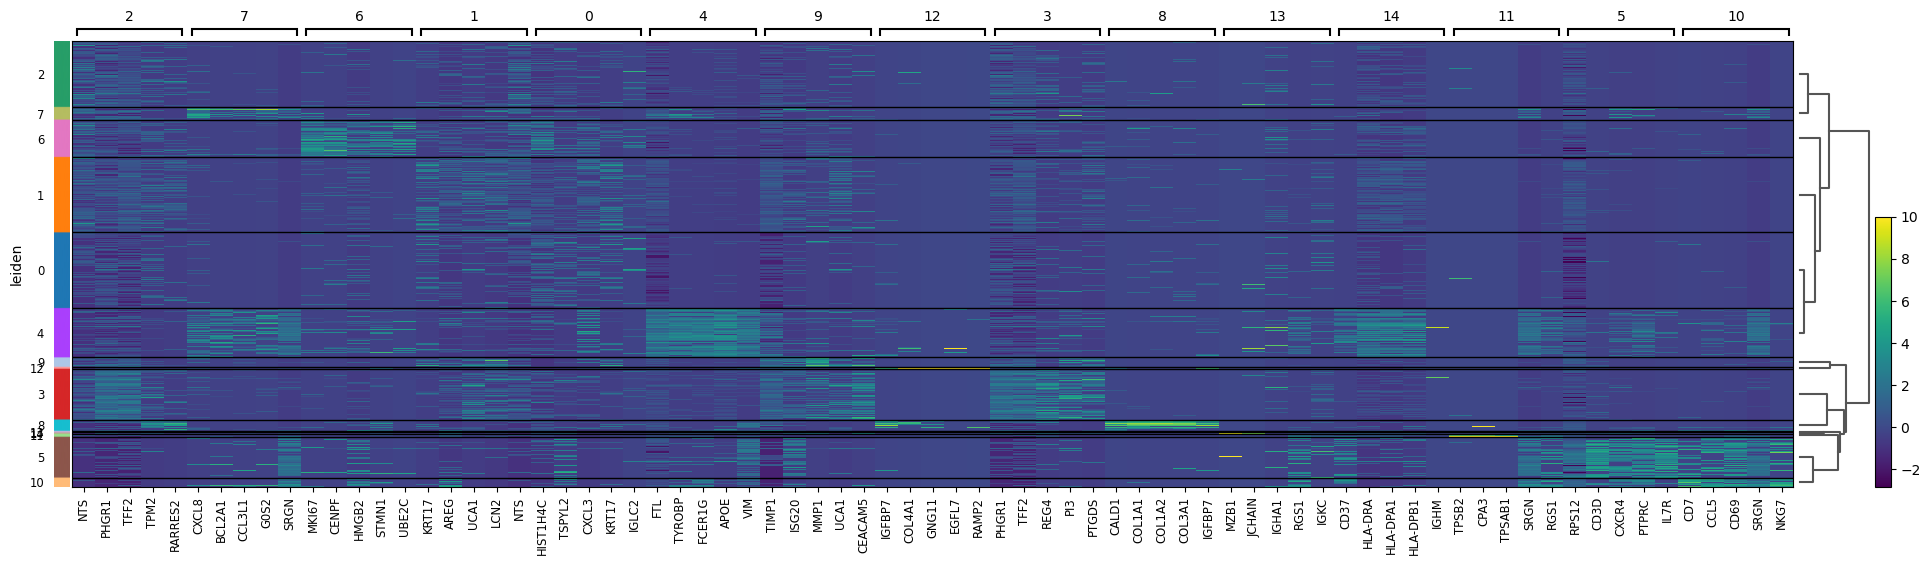

In [ ]:
import scanpy as sc
import pandas as pd
import os

# 0) (Re)load your saved object
adata = sc.read_h5ad('results/combined_all_samples2.h5ad')

# 1) Stash the log‐normalized matrix so we can compute true fold‐changes
adata.raw = adata

# 2) Rank genes for each leiden cluster vs. all others
sc.tl.rank_genes_groups(
    adata,
    groupby='leiden',
    method='wilcoxon',
    use_raw=True
)

# 3) View the top 5 markers for cluster “0”
df0 = sc.get.rank_genes_groups_df(adata, group='0')
print(df0.head(5))

# 4) DotPlot of the top 3 markers per cluster
sc.pl.rank_genes_groups_dotplot(
    adata,
    n_genes=3,
    groupby='leiden',
    standard_scale='var',
    dendrogram=True
)

# 5) Heatmap of the top 5 markers per cluster
sc.pl.rank_genes_groups_heatmap(
    adata,
    n_genes=5,
    groupby='leiden',
    show_gene_labels=True,
    dendrogram=True
)

# 6) Export all cluster markers to CSV
markers = sc.get.rank_genes_groups_df(adata, None)
os.makedirs('results', exist_ok=True)
markers.to_csv('results/cluster_markers_all.csv', index=False)


In [ ]:
# rank genes for tissue comparison
sc.tl.rank_genes_groups(
    adata,
    groupby='tissue',
    reference='Metastasis',    # or 'Normal' if you add that sample later
    method='wilcoxon'
)

# View top 10 Tumor-enriched genes
print(sc.get.rank_genes_groups_df(adata, group='Tumor').head(10))


      names     scores  logfoldchanges          pvals      pvals_adj
0     KRT17  35.715916             NaN  2.238236e-279  1.041040e-277
1   RARRES2  26.394753             NaN  1.574057e-153  3.537206e-152
2      CTGF  25.224455             NaN  2.160137e-140  4.194441e-139
3       NTS  24.017960             NaN  1.805410e-127  3.223947e-126
4      TPM2  23.136444             NaN  1.990657e-118  3.263372e-117
5  HIST1H4C  20.186462             NaN   1.287589e-90   1.866071e-89
6     LTC4S  15.308033             NaN   6.757643e-53   7.508493e-52
7      INSR  15.239068             NaN   1.946261e-52   2.138749e-51
8      AQP1  13.285513             NaN   2.809266e-40   2.795289e-39
9    COL1A1  13.236451             NaN   5.404262e-40   5.350754e-39


In [ ]:
# --- 0) (Re)load or pick up your processed AnnData ---
adata = sc.read_h5ad('results/combined_all_samples_scaled.h5ad')

# --- 1) Make sure your raw slot contains the full log1p matrix ---
#    (do this after your sc.pp.log1p but before any scaling/regression)
#    If you haven't already, you can still overwrite raw now:
adata.raw = adata  

# --- 2) (Re)run your DE for Tissue, using raw for FCs ---
sc.tl.rank_genes_groups(
    adata,
    groupby   = 'tissue',
    reference = 'Metastasis',
    method    = 'wilcoxon',
    use_raw   = True
)

# --- 3) Pull out the Tumor vs Met DE table correctly ---
#      Note: sc.get.rank_genes_groups_df takes only (adata, group)
df_tumor = sc.get.rank_genes_groups_df(adata, group='Tumor')

print(df_tumor[['names','logfoldchanges','pvals_adj']].head(10))


      names  logfoldchanges      pvals_adj
0     KRT17             NaN  1.041040e-277
1   RARRES2             NaN  3.537206e-152
2      CTGF             NaN  4.194441e-139
3       NTS             NaN  3.223947e-126
4      TPM2             NaN  3.263372e-117
5  HIST1H4C             NaN   1.866071e-89
6     LTC4S             NaN   7.508493e-52
7      INSR             NaN   2.138749e-51
8      AQP1             NaN   2.795164e-39
9    COL1A1             NaN   5.350754e-39


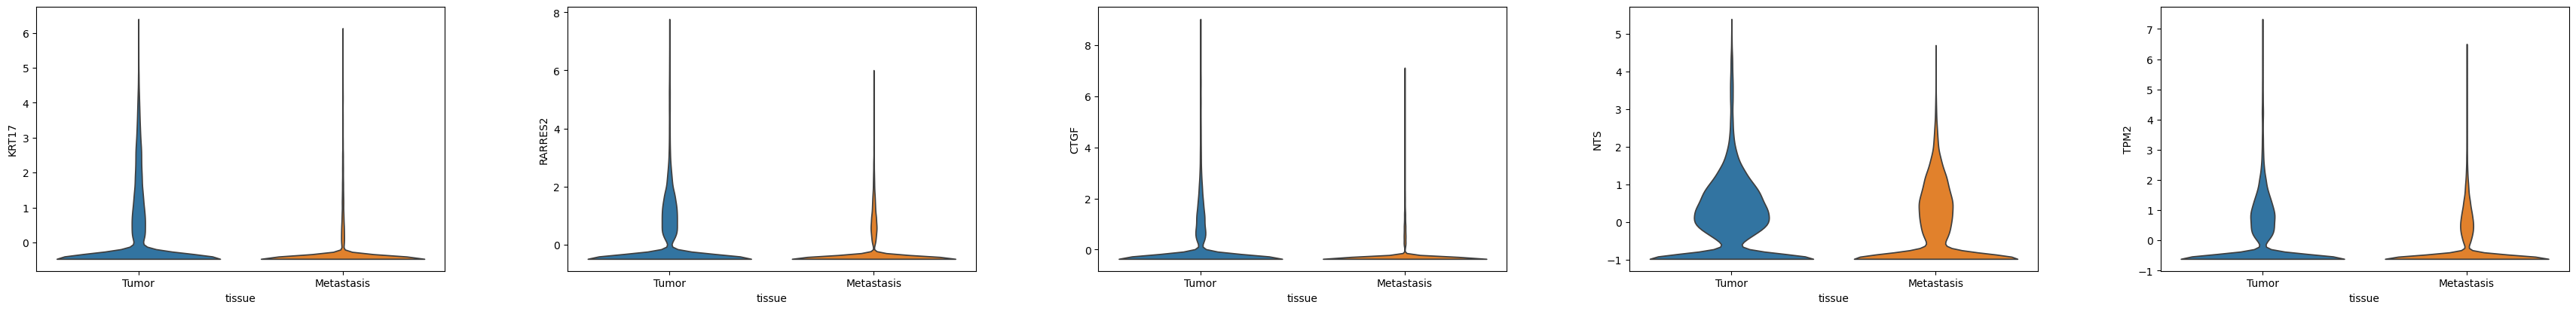

In [ ]:
# violin of the top 5 Tumor genes
top5 = df_tumor['names'].values[:5]
sc.pl.violin(
    adata,
    keys      = top5,
    groupby   = 'tissue',
    stripplot = False,
    jitter    = False,
    multi_panel=True
)


Final Project - single cell RNAseq

Paper 2: https://www.nature.com/articles/s41467-023-40727-7


If you use a jupyter notebook (scanpy), please also include a .YML file with the list of packages and versions you used. If you use a Rmarkdown (seurat), please include a printout from the sessionInfo() function in R with all of your utilized packages.

Please either knit your Rmarkdown to a HTML or render your jupyter notebook to a HTML report

Preprocessing
Perform appropriate QC for each of the samples in your dataset separately. In addition to the basic QC metrics, you should utilize a doublet detection tool of your choice.

Figures

Create a plot or plots that contain at minimum information on the number of unique genes detected per barcode, the total number of molecules per barcode, and the percentage of reads that map to the mitochondrial genome.

An integrated plot that visualizes the above metrics jointly for each sample.

Results from the doublet detection algorithm you employed

Create a table that displays how many cells / genes are present in your dataset before and after your filtering thresholds are implemented

Discussion

In your discussion, make sure to address the following points / questions:

What filtering thresholds did you choose and how did you decide on them?
How many cells / genes are present before and after implementing your filtering thresholds?
Look in the literature, what are some potential strategies to set thresholds that don’t rely on visual inspection of plots?
Count Normalization
Discussion

Choose a method to normalize the scRNAseq data and ensure that you explain the exact normalization procedure.

Feature Selection
Choose an appropriate method for feature selection and the number of highly variable features you will use in downstream analyses.

Figures

Create a plot of the highly variable features by your chosen metric.
Discussion

Explain the method used to determine highly variable features and report how many variable features you chose to use for downstream dimensional reduction.

Include a brief statement on how many genes meet your chosen threshold to be considered highly variable and how many are not considered

PCA
Perform dimensional reduction using PCA on your highly variable features.

Figures

Create a plot that justifies your choice of how many PCs to utilize in downstream analyses
Discussion

Justify your choice in writing and briefly remark on your plot.
Clustering and visualization
Decide on an appropriate method to cluster your cells and create a visualization of the 2D embedding (UMAP / T-SNE). Choose an appropriate resolution for the clustering algorithm.

Figures

Create a plot visualizing the clustering results of your cells. Ensure that it has labels that identify the different clusters as determined by the unsupervised clustering method you employed

Create a plot visualizing the clustering results of your cells. Ensure that it has labels that identify which samples each cell originated from.

Discussion

Write a brief paragraph describing the results up to this point. In it, ensure that you include the following information:

How many cells come from each sample individually? How many total cells present in the entire dataset?
How many clusters are present?
What clustering resolution did you use?
Use the second plot you created and briefly remark on whether you will perform integration.

Integration (optional)
If you determined from your clustering that the dataset would benefit from integration, please choose an appropriate method and apply it to your dataset.

Figures

Create a plot visualizing the clustering results of your cells before and after integration. Ensure that it has labels that identify which samples each cell originated from.
Discussion

Briefly remark on the plots and the effects you observe due to the integration
Marker Gene Analysis
Perform marker gene analysis using a method of your choice.

Figures

Create a table listing the top five marker genes for each of your clusters
Discussion

Briefly describe the method performed to identify marker genes. Discuss a few advantages and disadvantages of the method used to perform marker gene analysis.
Automatic Annotation of Cell labels
Use an annotation algorithm to assign preliminary labels for the cell identities of your clusters. You may use your choice of tool as long as it has a documented code base hosted publicly and has an associated publication describing its use.

Figures

Create a visualization of your cell clustering with the labels assigned by the results of running the labeling tool of your choice.
Discussion

Briefly remark on how the algorithm works and ensure you cite the original publication. You may paraphrase information from the publication.

Comment on the cell identities of your clusters and any speculation as to the original source tissue of the samples based on what you see

Manual Cluster Labeling
Perform literature searches using the marker gene analysis you performed before. In combination with the results from your cell annotation algorithm, provide a final determination of the cell identities for each of your clusters.

Figures

Create a single plot / figure that displays the top marker genes for every cluster in your dataset. This plot may be in any style (a heatmap, a tracksplot, violin plot, etc.)

For the top three clusters with the most cells, create individual plots of at least 5 of the defining marker genes for that cluster and their expression compared across all clusters

Create a visualization / plot of your clusters with your manual annotations and labels of cell identities.

Discussion

Write a paragraph describing your cell annotations and explaining what cell label you have assigned to each cluster. Ensure that you have at least one citation that supports your labeling and choice of marker genes for each cluster.
0.5 Replicate two of the major findings / analyses from the publication
Please look in the publication for the dataset and choose two of their major findings / experiments and attempt to replicate them with your own workflow.

These must be different and can involve any of the following types of analyses:

Pseudotime analysis (Monocle, Slingshot, CellRank, etc.)
RNA velocity analysis (scVelo, velocyto, etc.)
Cell Proportion analysis (scCODA, etc.)
Cell signaling analysis (CellChat, CellPhoneDB, etc.)
You do not need to reproduce entire panels of figures: it is enough to reproduce a single plot / figure that represents one of the major analyses above.

Figures

Produce one figure per analysis that represents the most interesting results
Discussion

Write a paragraph per analysis that highlights the top results discovered and includes at least one citation per analysis that represents a potential interpretation or hypothesis from the results.
Analysis of your choice that was not performed in the publication
For the last part of the project, you will choose one additional analysis to perform on the data. Whatever analysis you choose must not have been already performed by the publication and must be one of the main analyses listed above or substantial enough as determined by me (i.e. a simple plot is not enough)

You may choose a tool or algorithm with the same constraints as before (it must have a documented code base and an associated publication). You may choose any of the analyses listed above. Please contact me if you are not sure if an analysis is substantial enough.

Figures

Create a figure or figure(s) that display the most pertinent results from the analysis
Discussion

Briefly remark on the results and why they may be interesting. Provide at least one citation from the literature that represents a potential hypothesis or point of interest from the results you show.
Final Project Grading
The requirements for the final project are:

A single jupyter notebook or Rmarkdown that performs the above tasks, creates the required plots / visualizations and addresses the listed questions
The responses to the questions should be written in the style of a scientific publication, but you will be graded on the content. Each question can be answered in a short paragraph so we encourage you to be brief.